# MNIST handwritten digits dimensionality reduction with scikit-learn

In this notebook, we'll use some popular methods to reduce the dimensionality of MNIST digits data before classification.

[Section 1](#1.-Feature-extraction) of the notebook contains examples of feature extraction methods, and [Section 2](#2.-Feature-selection) two  methods for feature selection. Any of these methods can then be applied to train a MNIST digits classifier for lower-dimensional data in [Section 3](#3.-Classification-with-dimension-reduced-data).

First, the needed imports.

In [280]:
%matplotlib inline

from pml_utils import get_mnist

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import __version__
from sklearn import decomposition, feature_selection
from skimage.measure import block_reduce
from skimage.feature import canny
from sklearn.datasets import fetch_openml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from distutils.version import LooseVersion as LV
assert(LV(__version__) >= LV("0.20")), "Version >= 0.20 of sklearn is required."

#mnist = fetch_openml('mnist_784')

Then we load the MNIST data. First time it may download the data, which can take a while.

In [141]:
#from sklearn.model_selection import train_test_split

#X_train, y_train, X_test, y_test = train_test_split(mnist.data, mnist.target)
X_train, y_train, X_test, y_test = get_mnist('MNIST')

print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 784)
y_train: (60000,)
X_test (10000, 784)
y_test (10000,)


In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
y_train = scaler.transform(y_train)

print(X_train.shape)
print(y_train.shape)

(52500, 784)
(17500, 784)


## 1. Feature extraction

### 1.1 PCA

[Principal component analysis](http://scikit-learn.org/stable/modules/decomposition.html#pca) (PCA) is a standard method to decompose a high-dimensional dataset in a set of successive orthogonal components that explain a maximum amount of the variance. Here we project the data into `n_components` principal components. The components have the maximal possible variance under the orthogonality constraint.

The option `whiten=True` can be used to whiten the outputs to have unit component-wise variances.  Its usefulness depends on the model to be used.

In [142]:
%%time
n_components = 50
pca = decomposition.PCA(n_components=n_components, whiten=True)
X_pca = pca.fit_transform(X_train)
print('X_pca:', X_pca.shape)

X_pca: (60000, 50)
CPU times: user 12.1 s, sys: 868 ms, total: 12.9 s
Wall time: 2.05 s


We can inspect the amount of variance explained by the principal components.

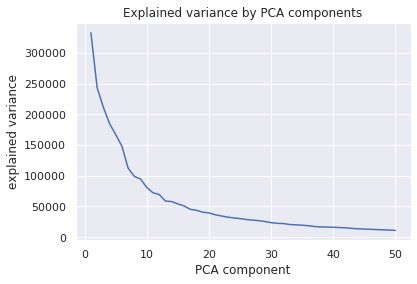

In [143]:
plt.figure()
plt.plot(np.arange(n_components)+1, pca.explained_variance_)
plt.title('Explained variance by PCA components')
plt.ylabel('explained variance')
plt.xlabel('PCA component');

### 1.2 Image feature extraction

There are a lot of different feature extraction methods for image data.  Common ones include extraction of colors, textures, and shapes from images, or detection of edges, corners, lines, blobs, or templates.  Let's try a simple filtering-based method to reduce the dimensionality of the features, and a widely-used edge detector.

The [`measure.block_reduce()`](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.block_reduce) function from scikit-image applies a function (for_example `np.mean`, `np.max` or `np.median`) to blocks of the image, resulting in a downsampled image.

In [144]:
X_train_img = X_train.reshape(-1, 28, 28)
filter_size = 2
X_train_img_downsampled = block_reduce(X_train_img, 
                                       block_size=(1, filter_size, filter_size), 
                                       func=np.mean)

print('X_train_img:', X_train_img.shape)
print('X_train_img_downsampled:', X_train_img_downsampled.shape)

X_train_img: (60000, 28, 28)
X_train_img_downsampled: (60000, 14, 14)


The [`feature.canny()`](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.canny) function applies the [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector) to extract edges from the image.  Processing all images may take a couple of minutes.

In [145]:
%%time

sigma = 1.0
X_train_img_canny = np.zeros(X_train_img.shape)
for i in range(X_train_img.shape[0]):
    X_train_img_canny[i,:,:] = canny(X_train_img[i,:,:], sigma=sigma)
print('X_train_img_canny:', X_train_img_canny.shape)

X_train_img_canny: (60000, 28, 28)
CPU times: user 42.6 s, sys: 284 ms, total: 42.9 s
Wall time: 42.9 s


Let's compare the original and filtered digit images:

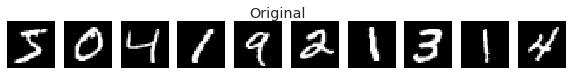

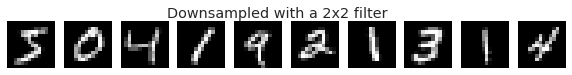

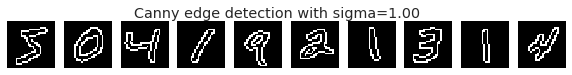

In [146]:
pltsize=1

plt.figure(figsize=(10*pltsize, pltsize))
plt.suptitle('Original')
plt.subplots_adjust(top=0.8)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train_img[i,:,:], cmap="gray", interpolation='none')

plt.figure(figsize=(10*pltsize, pltsize))
plt.suptitle('Downsampled with a %dx%d filter' % (filter_size, filter_size))
plt.subplots_adjust(top=0.8)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train_img_downsampled[i,:,:], cmap="gray", interpolation='none')
    
plt.figure(figsize=(10*pltsize, pltsize))
plt.suptitle('Canny edge detection with sigma=%.2f' % sigma)
plt.subplots_adjust(top=0.8)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train_img_canny[i,:,:], cmap="gray", interpolation='none')

## 2. Feature selection

### 2.1 Low variance

The MNIST digits have a lot of components (pixels) with little variance.  These components are not particularly useful for discriminating between the classes, so they can probably be removed safely.  Let's first draw the component-wise variances of MNIST data.

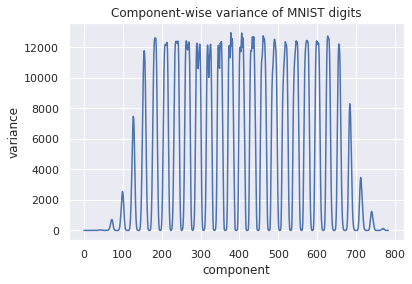

In [147]:
variances = np.var(X_train, axis=0)
plt.figure()
plt.plot(variances)
plt.title('Component-wise variance of MNIST digits')
plt.ylabel('variance')
plt.xlabel('component');

The variances can also be plotted for each pixel in the image plane.

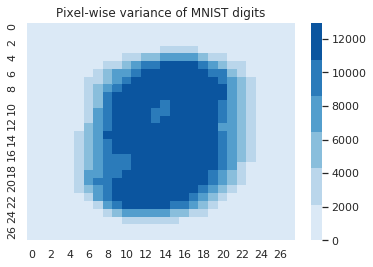

In [148]:
plt.figure()
sns.heatmap(variances.reshape(28,28), cmap=sns.color_palette("Blues"))
plt.title('Pixel-wise variance of MNIST digits')
plt.grid(False)

Select an appropriate `variance_threshold` based on the *"Component-wise variance of MNIST digits"* figure above.

In [149]:
%%time

variance_threshold = 1000
lv = feature_selection.VarianceThreshold(threshold=variance_threshold)
X_lv = lv.fit_transform(X_train)
print('X_lv:', X_lv.shape)

X_lv: (60000, 412)
CPU times: user 600 ms, sys: 72 ms, total: 672 ms
Wall time: 671 ms


### 2.2 Univariate feature selection

Another method for feature selection is to select the *k* best features based on univariate statistical tests between the features and the class of each sample.  Therefore, this is a supervised method and we need to include `y_train` in `fit_transform()`.
See [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) for the set of available statistical tests and other further options.

In [150]:
%%time

k = 50
ukb = feature_selection.SelectKBest(k=k)
X_ukb = ukb.fit_transform(X_train, y_train)
print('X_ukb:', X_ukb.shape)

X_ukb: (60000, 50)
CPU times: user 501 ms, sys: 144 ms, total: 645 ms
Wall time: 645 ms


/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  52  53  54  55  56  57  82  83
  84  85 111 112 140 141 168 476 560 644 645 671 672 673 699 700 701 727
 728 729 730 754 755 756 757 758 759 780 781 782 783] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


We can check which features (that is, pixels in case) got selected:

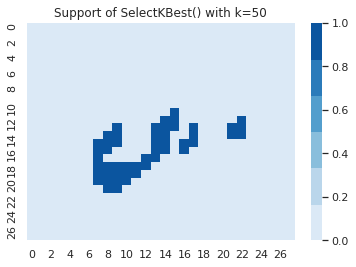

In [151]:
support = ukb.get_support()
plt.figure()
sns.heatmap(support.reshape(28,28), cmap=sns.color_palette("Blues"))
#with sns.axes_style("white"):
#    plt.imshow(support.reshape(28,28), interpolation='none')
plt.title('Support of SelectKBest() with k=%d' % k)
plt.grid(False)

## 3. Classification with dimension-reduced data 

Let's now train a classifier using lower-dimensional data. Choose any of the above feature extraction or feature selection methods, and reduce the dimensionality of the MNIST data with that method. You can also implement your own dimensionaly reduction method.

Note that you need to transform also the test data into the lower-dimensional space using `transform()`.  Here is an example for PCA:

In [152]:
X_test_pca = pca.transform(X_test)
print('X_test_pca:', X_test_pca.shape)

X_test_pca: (10000, 50)


Select a classification method from the ones that have been discussed on the previous lectures. For example, nearest neighbor classifiers or decision trees are good choices. Compare the results (accuracy, time) to classification using the original MNIST data.


## Decision tree

In [186]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [205]:
%%time

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

CPU times: user 21.5 s, sys: 35.4 ms, total: 21.6 s
Wall time: 21.6 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [206]:
%%time

pred_dt = clf_dt.predict(X_test)
print('Predicted', len(pred_dt), 'digits with accuracy:', accuracy_score(y_test, pred_dt))

Predicted 10000 digits with accuracy: 0.8776
CPU times: user 15.4 ms, sys: 7.76 ms, total: 23.1 ms
Wall time: 21.9 ms


## Saving tree into text file and pdf

In [207]:
import graphviz

export_graphviz(clf_dt, out_file="mydt.dot")
with open("mydt.dot") as f:
    dot_graph = f.read()
a=graphviz.Source(dot_graph)
print('Wrote PDF file:', a.render('mydt', view=False))

Wrote PDF file: mydt.pdf


## (Optional) Plotting a sample of the tree

In [259]:
%%time

clf_dt_s = DecisionTreeClassifier(max_depth=3)
clf_dt_s.fit(X_train, y_train)

CPU times: user 4.6 s, sys: 40.6 ms, total: 4.64 s
Wall time: 4.65 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

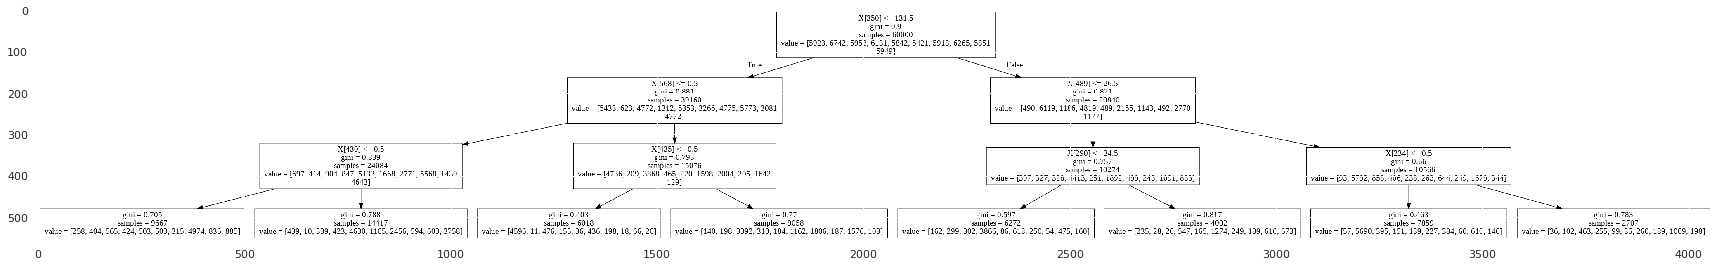

In [279]:
import graphviz

export_graphviz(clf_dt_s, out_file="mydt.dot")
with open("mydt.dot") as f:
    dot_graph = f.read()
a=graphviz.Source(dot_graph)
a.format = 'png'
a.render('mydt',view=True)

import matplotlib.image as mpimg

plt.figure(figsize=(30, 30))
img = mpimg.imread('mydt.png')
plt.imshow(img)
plt.show()

#print('Wrote PDF file:', a.render('mydt', view=False))

In [260]:
%%time

pred_dt_s = clf_dt_s.predict(X_test)
print('Predicted', len(pred_dt_s), 'digits with accuracy:', accuracy_score(y_test, pred_dt_s))

Predicted 10000 digits with accuracy: 0.4953
CPU times: user 25.6 ms, sys: 0 ns, total: 25.6 ms
Wall time: 24.1 ms


In [252]:
%%time

pca = DecisionTreeClassifier()
pca.fit(X_pca, y_train)

CPU times: user 10 s, sys: 920 µs, total: 10 s
Wall time: 10 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [253]:
pred_dt_pca = pca.predict(X_test_pca)
print('Predicted', len(pred_dt_pca), 'digits with accuracy:', accuracy_score(y_test, pred_dt_pca))

Predicted 10000 digits with accuracy: 0.8407


## Comparing how effective PCA is

In [256]:
print("With PCA: ", accuracy_score(y_test, pred_dt_pca), "\nWithout PCA: ", accuracy_score(y_test, pred_dt))

With PCA:  0.8407 
Without PCA:  0.8776


## 4. Other methods for dimensionality reduction

Study and experiment with additional dimensionality reduction methods based on [decomposing](http://scikit-learn.org/stable/modules/decomposition.html) or [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html).  See also [unsupervised dimensionality reduction](http://scikit-learn.org/stable/modules/unsupervised_reduction.html).

## Decomposition

In [210]:
from sklearn.decomposition import PCA
mnist = fetch_openml('mnist_784')

In [214]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


X = mnist.data
y = mnist.target
target_names = mnist.target_names
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [226]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.09746116 0.07155445]


In [230]:
y_r = np.reshape(y, (-1, 2))

print(X_r.shape)
print(y_r.shape)

(70000, 2)
(35000, 2)


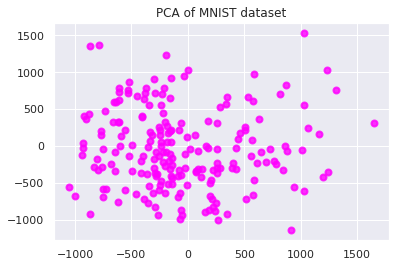

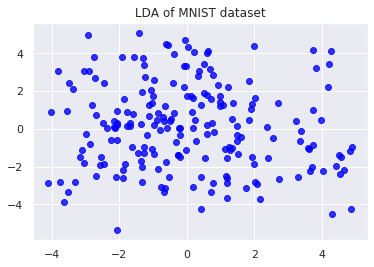

In [249]:
plt.figure()
lw = 2

plt.scatter(X_r[0:100], X_r[100:200], color='magenta', alpha=.8, lw=lw)
#plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of MNIST dataset')

plt.figure()
plt.scatter(X_r2[0:100], X_r2[100:200], alpha=.8, color="blue")
#plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of MNIST dataset')

plt.show()